<div class="alert alert-success" style = "border-radius:10px;border-width:3px;border-color:white;font-family:Verdana,sans-serif;font-size:16px;">
<h2>Mixture Density Networks (MDN) for distribution and uncertainty estimation </h2>

This material is copyright Axel Brando and made available under the Creative Commons Attribution-ShareAlike 4.0 International License (http://creativecommons.org/licenses/by-sa/4.0/). Code is also made available under the Apache Version 2.0 License (https://www.apache.org/licenses/LICENSE-2.0). 

Please, to use this material and code follow the instructions explained in the main repository [https://github.com/axelbrando/Mixture-Density-Networks-for-distribution-and-uncertainty-estimation](https://github.com/axelbrando/Mixture-Density-Networks-for-distribution-and-uncertainty-estimation#bibtex-reference-format-for-citation)

<div class="alert alert-info" style = "border-radius:10px;border-width:3px;border-color:white;font-family:Verdana,sans-serif;font-size:16px;">
<h3>Trying to predict uncertainty by using Deep Ensemble</h3>
Below we will show a implementation of the following points:
<ul>
    <li>The article of Lakshminarayanan et al. (DeepMind London) *Simple and Scalable Predictive Uncertainty Estimation using Deep Ensembles.*</li>
    <li>With the other tricks described in the main page of the repository https://github.com/axelbrando/Mixture-Density-Networks-for-distribution-and-uncertainty-estimation</li>
</ul>
</div>

In [1]:
import tensorflow as tf
tf.python.control_flow_ops = tf

config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

from keras.models import Sequential,Graph
from keras.layers.core import Dense, Dropout
from keras.callbacks import History
from keras.layers.recurrent import LSTM
from keras.models import model_from_json
from keras.regularizers import l2, activity_l2

from keras import backend as K

import numpy as np

Using TensorFlow backend.


In [274]:
c = 1
m = 1

c = 1 #The number of outputs we want to predict
m = 1 #The number of distributions we want to use in the mixture

#Note: The output size will be (c + 2) * m

def log_sum_exp(x, axis=None):
    """Log-sum-exp trick implementation"""
    x_max = K.max(x, axis=axis, keepdims=True)
    return K.log(K.sum(K.exp(x - x_max), 
                       axis=axis, keepdims=True))+x_max


def mean_log_Gaussian_like(y_true, parameters):
    """Mean Log Gaussian Likelihood distribution
    Note: The 'c' variable is obtained as global variable
    """
    components = K.reshape(parameters,[-1, c + 2, m])
    mu = components[:, :c, :]
    sigma = components[:, c, :]
    alpha = components[:, c + 1, :]
    alpha = K.softmax(K.clip(alpha,1e-8,1.))
    
    exponent = K.log(alpha) - .5 * float(c) * K.log(2 * np.pi) \
    - float(c) * K.log(sigma) \
    - K.sum((K.expand_dims(y_true,2) - mu)**2, axis=1)/(2*(sigma)**2)
    
    log_gauss = log_sum_exp(exponent, axis=1)
    res = - K.mean(log_gauss)
    return res


def mean_log_LaPlace_like(y_true, parameters):
    """Mean Log Laplace Likelihood distribution
    Note: The 'c' variable is obtained as global variable
    """
    components = K.reshape(parameters,[-1, c + 2, m])
    mu = components[:, :c, :]
    sigma = components[:, c, :]
    alpha = components[:, c + 1, :]
    alpha = K.softmax(K.clip(alpha,1e-2,1.))
    
    exponent = K.log(alpha) - float(c) * K.log(2 * sigma) \
    - K.sum(K.abs(K.expand_dims(y_true,2) - mu), axis=1)/(sigma)
    
    log_gauss = log_sum_exp(exponent, axis=1)
    res = - K.mean(log_gauss)
    return res


def scoring_rule_adv(y_true, y_pred):
    """Fast Gradient Sign Method (FSGM) to implement Adversarial Training
    Note: The 'graphADV' pointer is obtained as global variable
    """
    
    # Compute loss 
    #Note: Replace with 'mean_log_Gaussian_like' if you want a Gaussian kernel.
    error = mean_log_LaPlace_like(y_true, y_pred)
    
    # Craft adversarial examples using Fast Gradient Sign Method (FGSM)
    # Define gradient of loss wrt input
    grad_error = K.gradients(error,graphADV.input) #Minus is on error function
    # Take sign of gradient, Multiply by constant epsilon, Add perturbation to original example to obtain adversarial example
    #Sign add a new dimension we need to obviate
    
    epsilon = 0.08
    
    ##adversarial_X = K.stop_gradient(graphADV.input + epsilon * K.sign(grad_error)[0])
    
    # Note: If you want to test the variation of adversarial training 
    #  proposed by XX, eliminate the following comment character 
    #  and comment the previous one.
    
    adversarial_X = graphADV.input + epsilon * K.sign(grad_error)[0]
    
    adv_output = graphADV(adversarial_X)
    
    #Note: Replace with 'mean_log_Gaussian_like' if you want a Gaussian kernel.
    adv_error = mean_log_LaPlace_like(y_true, adv_output)
    return 0.3 * error + 0.7 * adv_error

In [256]:
graphN1 = Graph()
graphN1.add_input(name='input', input_shape=(1,), dtype='float32')
graphN1.add_node(Dense(output_dim=8, activation="relu"), name='FC1', input='input')
graphN1.add_node(Dense(output_dim=c*m), name='FC_mus', input='FC1')
graphN1.add_node(Dense(output_dim=m, activation=K.exp, W_regularizer=l2(1e-3)), name='FC_sigmas', input='FC1')
graphN1.add_node(Dense(output_dim=m, activation='softmax'), name='FC_alphas', input='FC1')
graphN1.add_output(name='output', inputs=['FC_mus','FC_sigmas', 'FC_alphas'], merge_mode='concat',concat_axis=1)
graphADV = graphN1
graphN1.compile(optimizer='adam', loss={'output':scoring_rule_adv})

In [279]:
graphN2 = Graph()
graphN2.add_input(name='input', input_shape=(1,), dtype='float32')
graphN2.add_node(Dense(output_dim=8, activation="relu"), name='FC1', input='input')
graphN2.add_node(Dense(output_dim=c*m), name='FC_mus', input='FC1')
graphN2.add_node(Dense(output_dim=m, activation=K.exp), name='FC_sigmas', input='FC1')
graphN2.add_node(Dense(output_dim=m, activation='softmax'), name='FC_alphas', input='FC1')
graphN2.add_output(name='output', inputs=['FC_mus','FC_sigmas', 'FC_alphas'], merge_mode='concat',concat_axis=1)
graphADV = graphN2
graphN2.compile(optimizer='adam', loss={'output':scoring_rule_adv})

In [280]:
graphN3 = Graph()
graphN3.add_input(name='input', input_shape=(1,), dtype='float32')
graphN3.add_node(Dense(output_dim=8, activation="relu"), name='FC1', input='input')
graphN3.add_node(Dense(output_dim=c*m), name='FC_mus', input='FC1')
graphN3.add_node(Dense(output_dim=m, activation=K.exp), name='FC_sigmas', input='FC1')
graphN3.add_node(Dense(output_dim=m, activation='softmax'), name='FC_alphas', input='FC1')
graphN3.add_output(name='output', inputs=['FC_mus','FC_sigmas', 'FC_alphas'], merge_mode='concat',concat_axis=1)
graphADV = graphN3
graphN3.compile(optimizer='adam', loss={'output':scoring_rule_adv})

In [281]:
graphN4 = Graph()
graphN4.add_input(name='input', input_shape=(1,), dtype='float32')
graphN4.add_node(Dense(output_dim=8, activation="relu"), name='FC1', input='input')
graphN4.add_node(Dense(output_dim=c*m), name='FC_mus', input='FC1')
graphN4.add_node(Dense(output_dim=m, activation=K.exp), name='FC_sigmas', input='FC1')
graphN4.add_node(Dense(output_dim=m, activation='softmax'), name='FC_alphas', input='FC1')
graphN4.add_output(name='output', inputs=['FC_mus','FC_sigmas', 'FC_alphas'], merge_mode='concat',concat_axis=1)
graphADV = graphN4
graphN4.compile(optimizer='adam', loss={'output':scoring_rule_adv})

In [282]:
graphN5 = Graph()
graphN5.add_input(name='input', input_shape=(1,), dtype='float32')
graphN5.add_node(Dense(output_dim=8, activation="relu"), name='FC1', input='input')
graphN5.add_node(Dense(output_dim=c*m), name='FC_mus', input='FC1')
graphN5.add_node(Dense(output_dim=m, activation=K.exp), name='FC_sigmas', input='FC1')
graphN5.add_node(Dense(output_dim=m, activation='softmax'), name='FC_alphas', input='FC1')
graphN5.add_output(name='output', inputs=['FC_mus','FC_sigmas', 'FC_alphas'], merge_mode='concat',concat_axis=1)
graphADV = graphN5
graphN5.compile(optimizer='adam', loss={'output':scoring_rule_adv})

Data set with or without noise

In [8]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

NSAMPLE = 1000
X = np.concatenate((np.float32(np.random.uniform(-4, -1, (1, NSAMPLE/2))),
                np.float32(np.random.uniform(1, 4, (1, NSAMPLE/2)))),
               axis=1)
r_data = np.random.normal(scale=3.,size=X.shape)
y = np.float32(np.power(X,3)+r_data)

X = X.T
y = y.T

In [104]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

NSAMPLE = 1000
X = np.concatenate((np.float32(np.random.uniform(-4, -1, (1, NSAMPLE/2))),
                np.float32(np.random.uniform(1, 4, (1, NSAMPLE/2)))),
               axis=1)
r_data = np.random.normal(scale=3.,size=X.shape)
y = np.float32(np.power(X,3))

X = X.T
y = y.T

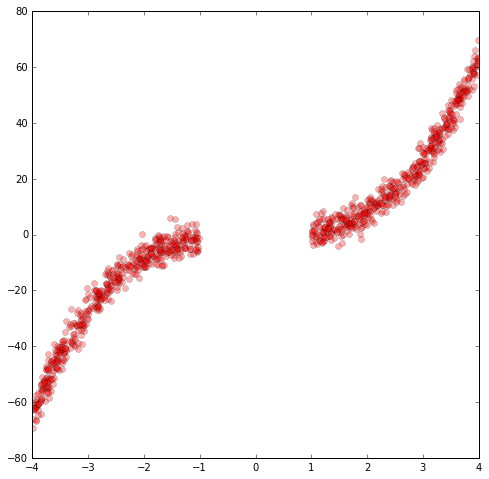

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(8, 8))
plot_out = plt.plot(X,y,'ro',alpha=0.3)
plt.show()

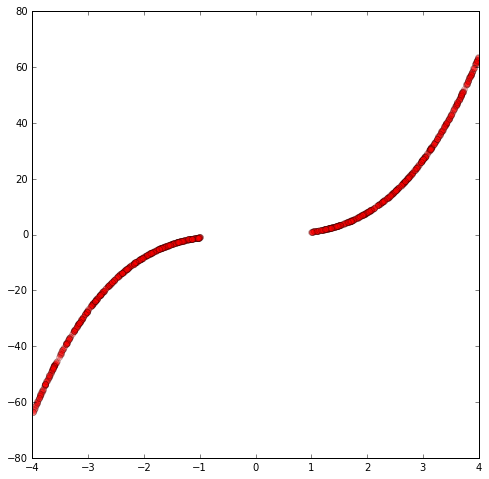

In [105]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(8, 8))
plot_out = plt.plot(X,y,'ro',alpha=0.3)
plt.show()

In [277]:
X,y = unison_shuffled_copies(X, y)

from datetime import datetime
start_time = datetime.now()
epoch=20000#abans 40
#8000
graphN1.fit(data={'input':X,'output':y}, batch_size=500, nb_epoch=epoch, 
          validation_split=0.1, verbose = 0) #[np.tile(y,(1,c*m)),y] 
end_time = datetime.now()
a=0
print 
print "*********************************  End  *********************************"
print
print('Duration: {}'.format(end_time - start_time))


*********************************  End  *********************************

Duration: 0:10:18.969904


In [283]:
X,y = unison_shuffled_copies(X, y)

from datetime import datetime
start_time = datetime.now()
epoch=20000
graphN2.fit(data={'input':X,'output':y}, batch_size=500, nb_epoch=epoch, 
          validation_split=0.1, verbose = 0)
end_time = datetime.now()
a=0
print 
print "*********************************  End  *********************************"
print
print('Duration: {}'.format(end_time - start_time))


*********************************  End  *********************************

Duration: 0:15:13.262165


In [284]:
X,y = unison_shuffled_copies(X, y)

from datetime import datetime
start_time = datetime.now()
epoch=20000
graphN3.fit(data={'input':X,'output':y}, batch_size=500, nb_epoch=epoch, 
          validation_split=0.1, verbose = 0)
end_time = datetime.now()
a=0
print 
print "*********************************  End  *********************************"
print
print('Duration: {}'.format(end_time - start_time))


*********************************  End  *********************************

Duration: 0:15:31.743126


In [285]:
X,y = unison_shuffled_copies(X, y)

from datetime import datetime
start_time = datetime.now()
epoch=20000
graphN4.fit(data={'input':X,'output':y}, batch_size=500, nb_epoch=epoch, 
          validation_split=0.1, verbose = 0)
end_time = datetime.now()
a=0
print 
print "*********************************  End  *********************************"
print
print('Duration: {}'.format(end_time - start_time))


*********************************  End  *********************************

Duration: 0:11:31.825447


In [286]:
X,y = unison_shuffled_copies(X, y)

from datetime import datetime
start_time = datetime.now()
epoch=4000
graphN5.fit(data={'input':X,'output':y}, batch_size=500, nb_epoch=epoch, 
          validation_split=0.1, verbose = 0)
end_time = datetime.now()
a=0
print 
print "*********************************  End  *********************************"
print
print('Duration: {}'.format(end_time - start_time))


*********************************  End  *********************************

Duration: 0:03:31.885095


In [88]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

NSAMPLE = 1000
X_val = np.float32(np.random.uniform(-10, 10, (1, NSAMPLE/2)))

y_val = np.float32(np.power(X_val,3))

X_val = X_val.T
y_val = y_val.T

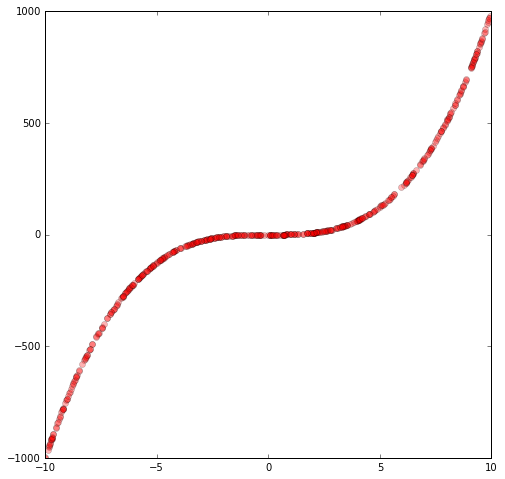

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(8, 8))
plot_out = plt.plot(X_val,y_val,'ro',alpha=0.3)
plt.show()

In [287]:
parameters = graphN1.predict(data={'input':X_val})['output']

comp = np.reshape(parameters,[-1, c + 2, m])
mu_pred1 = comp[:, :c, :]
sigma_pred1 = comp[:, c, :]
alpha_pred1 = comp[:, c + 1, :]

parameters = graphN2.predict(data={'input':X_val})['output']

comp = np.reshape(parameters,[-1, c + 2, m])
mu_pred2 = comp[:, :c, :]
sigma_pred2 = comp[:, c, :]
alpha_pred2 = comp[:, c + 1, :]

parameters = graphN3.predict(data={'input':X_val})['output']

comp = np.reshape(parameters,[-1, c + 2, m])
mu_pred3 = comp[:, :c, :]
sigma_pred3 = comp[:, c, :]
alpha_pred3 = comp[:, c + 1, :]

parameters = graphN4.predict(data={'input':X_val})['output']

comp = np.reshape(parameters,[-1, c + 2, m])
mu_pred4 = comp[:, :c, :]
sigma_pred4 = comp[:, c, :]
alpha_pred4 = comp[:, c + 1, :]

parameters = graphN5.predict(data={'input':X_val})['output']

comp = np.reshape(parameters,[-1, c + 2, m])
mu_pred5 = comp[:, :c, :]
sigma_pred5 = comp[:, c, :]
alpha_pred5 = comp[:, c + 1, :]

In [ ]:
mu_pred_s = (mu_pred1+mu_pred2+mu_pred3+mu_pred4+mu_pred5)/5.

sigma_pred_s = np.sqrt((((sigma_pred1**2+mu_pred1[...,0]**2)+\
(sigma_pred2**2+mu_pred2[...,0]**2)+\
(sigma_pred3**2+mu_pred3[...,0]**2)+\
(sigma_pred4**2+mu_pred4[...,0]**2)+\
(sigma_pred5**2+mu_pred5[...,0]**2))/5.)-mu_pred_s[...,0]**2)

### Test without weight normalisation in the $\sigma$ output

Absolute error 67139.7


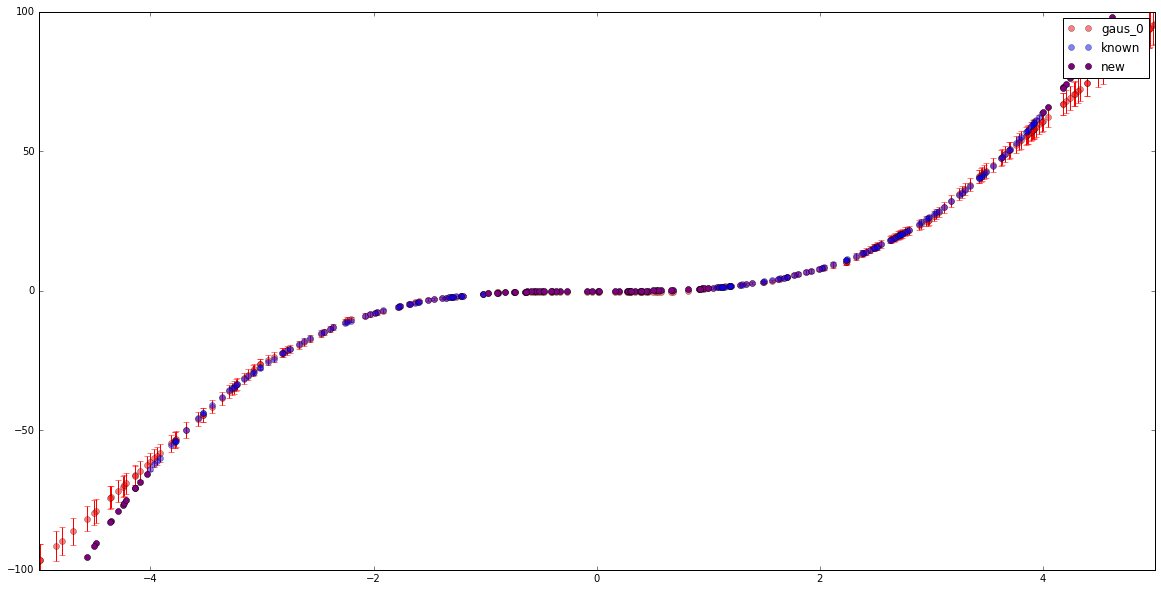

In [278]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as pyplot
from matplotlib import lines
import matplotlib.cm as cm

parameters = graphN2.predict(data={'input':X_val})['output']

comp = np.reshape(parameters,[-1, c + 2, m])
mu_pred = comp[:, :c, :]
sigma_pred = comp[:, c, :]
alpha_pred = comp[:, c + 1, :]
y_pred = np.zeros((len(mu_pred)))

col = cm.autumn(np.linspace(0, 1, mu_pred.shape[-1]))

for mx in xrange(mu_pred.shape[-1]):
    for i in xrange(len(mu_pred)):
        pyplot.errorbar(X_val[i],mu_pred[i,0,mx],
                        yerr=sigma_pred[i,mx],
                        alpha=alpha_pred[i,mx], 
                        color=col[mx])
        y_pred[i] = mu_pred[i,0,mx]
    pyplot.plot(X_val,y_pred, color=col[mx],linewidth=1, marker='o', 
            linestyle=' ',alpha=0.5, label='gaus_'+str(mx))

knownP = (((X_val>-4) & (X_val<-1)) | ((X_val>1) & (X_val<4)))

pyplot.plot(X_val[knownP],y_val[knownP], color='blue', 
            linewidth=1, marker='o', linestyle=' ',alpha=0.5, label='known')

pyplot.plot(X_val[knownP==0],y_val[knownP==0], color='purple', 
            linewidth=1, marker='o', linestyle=' ',alpha=1, label='new')

axes = pyplot.gca()

from matplotlib import collections  as mc
axes.set_ylim(-100,100)
axes.set_xlim(-5,5)
pyplot.gcf().set_size_inches((20,10))
pyplot.legend()
print 'Absolute error', np.min(np.abs(np.expand_dims(y_val,axis=2)-mu_pred),axis=2).sum()

Absolute error 65882.1


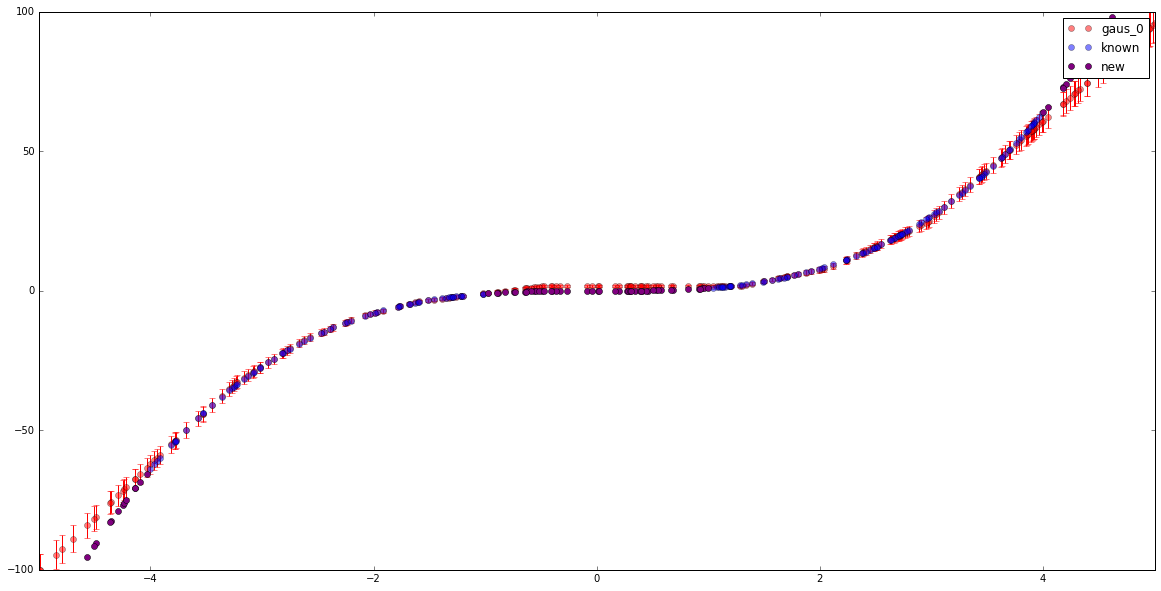

In [240]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as pyplot
from matplotlib import lines
import matplotlib.cm as cm
#v_rang = 100

parameters = graphN1.predict(data={'input':X_val})['output']

comp = np.reshape(parameters,[-1, c + 2, m])
mu_pred = comp[:, :c, :]
sigma_pred = comp[:, c, :]
alpha_pred = comp[:, c + 1, :]
y_pred = np.zeros((len(mu_pred)))

#col = ['#A96E6E', '#D93636', '#E3701A', '#D04545', 
#       '#F70000', '#FC1501', '#FF5333', '#BF6666',
#       '#FF3300', '#CD3700', '#8B2500', '#5E2605',
#       '#E69898']

#ax.set_color_cycle(col[:mu_pred.shape[-1]])#
col = cm.autumn(np.linspace(0, 1, mu_pred.shape[-1]))

for mx in xrange(mu_pred.shape[-1]):
    for i in xrange(len(mu_pred)):
        pyplot.errorbar(X_val[i],mu_pred[i,0,mx],
                        yerr=sigma_pred[i,mx],
                        alpha=alpha_pred[i,mx], 
                        color=col[mx])
        y_pred[i] = mu_pred[i,0,mx]
    pyplot.plot(X_val,y_pred, color=col[mx],linewidth=1, marker='o', 
            linestyle=' ',alpha=0.5, label='gaus_'+str(mx))

knownP = (((X_val>-4) & (X_val<-1)) | ((X_val>1) & (X_val<4)))

pyplot.plot(X_val[knownP],y_val[knownP], color='blue', 
            linewidth=1, marker='o', linestyle=' ',alpha=0.5, label='known')

pyplot.plot(X_val[knownP==0],y_val[knownP==0], color='purple', 
            linewidth=1, marker='o', linestyle=' ',alpha=1, label='new')

axes = pyplot.gca()
#origins = zip(np.arange(rang)*1.,y_val)
#endings = zip(np.arange(rang)*1.,y_pred)
#lines_vals = [[origins[i],endings[i]] for i in xrange(len(origins))]

from matplotlib import collections  as mc
#lc = mc.LineCollection(lines_vals, linewidths=1, alpha = 0.4, color = 'purple')
#axes.add_collection(lc)
axes.set_ylim(-100,100)
axes.set_xlim(-5,5)
pyplot.gcf().set_size_inches((20,10))
pyplot.legend()
print 'Absolute error', np.min(np.abs(np.expand_dims(y_val,axis=2)-mu_pred),axis=2).sum()

In [250]:
parameters = graphN1.predict(data={'input':X_val})['output']

comp = np.reshape(parameters,[-1, c + 2, m])
mu_pred1 = comp[:, :c, :]
sigma_pred1 = comp[:, c, :]
alpha_pred1 = comp[:, c + 1, :]

parameters = graphN2.predict(data={'input':X_val})['output']

comp = np.reshape(parameters,[-1, c + 2, m])
mu_pred2 = comp[:, :c, :]
sigma_pred2 = comp[:, c, :]
alpha_pred2 = comp[:, c + 1, :]

parameters = graphN3.predict(data={'input':X_val})['output']

comp = np.reshape(parameters,[-1, c + 2, m])
mu_pred3 = comp[:, :c, :]
sigma_pred3 = comp[:, c, :]
alpha_pred3 = comp[:, c + 1, :]

parameters = graphN4.predict(data={'input':X_val})['output']

comp = np.reshape(parameters,[-1, c + 2, m])
mu_pred4 = comp[:, :c, :]
sigma_pred4 = comp[:, c, :]
alpha_pred4 = comp[:, c + 1, :]

parameters = graphN5.predict(data={'input':X_val})['output']

comp = np.reshape(parameters,[-1, c + 2, m])
mu_pred5 = comp[:, :c, :]
sigma_pred5 = comp[:, c, :]
alpha_pred5 = comp[:, c + 1, :]

In [251]:
mu_pred_s = (mu_pred1+mu_pred2+mu_pred3+mu_pred4+mu_pred5)/5.

sigma_pred_s = np.sqrt((((sigma_pred1**2+mu_pred1[...,0]**2)+\
(sigma_pred2**2+mu_pred2[...,0]**2)+\
(sigma_pred3**2+mu_pred3[...,0]**2)+\
(sigma_pred4**2+mu_pred4[...,0]**2)+\
(sigma_pred5**2+mu_pred5[...,0]**2))/5.)-mu_pred_s[...,0]**2)

Absolute error 70645.3


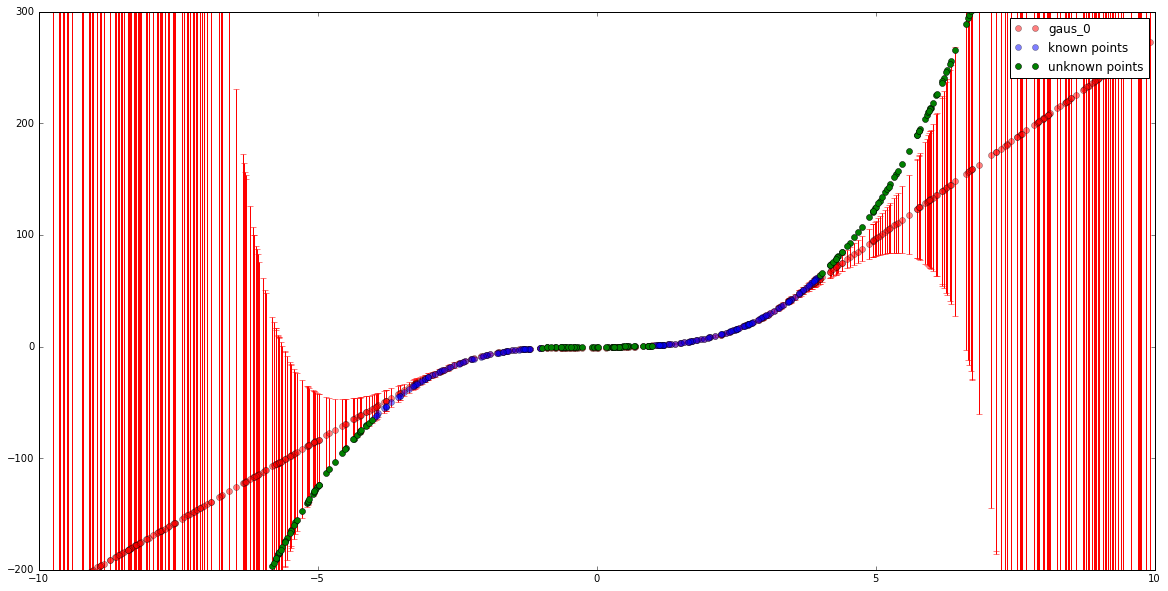

In [289]:
mu_pred = mu_pred_s
sigma_pred = sigma_pred_s
alpha_pred = alpha_pred5
y_pred = np.zeros((len(mu_pred)))

col = cm.autumn(np.linspace(0, 1, mu_pred.shape[-1]))

for mx in xrange(mu_pred.shape[-1]):
    for i in xrange(len(mu_pred)):
        pyplot.errorbar(X_val[i],mu_pred[i,0,mx],
                        yerr=sigma_pred[i,mx],
                        alpha=alpha_pred[i,mx], 
                        color=col[mx])
        y_pred[i] = mu_pred[i,0,mx]
    pyplot.plot(X_val,y_pred, color=col[mx],linewidth=1, marker='o', 
            linestyle=' ',alpha=0.5, label='gaus_'+str(mx))

knownP = (((X_val>-4) & (X_val<-1)) | ((X_val>1) & (X_val<4)))

pyplot.plot(X_val[knownP],y_val[knownP], color='blue', 
            linewidth=1, marker='o', linestyle=' ',alpha=0.5, label='known points')

pyplot.plot(X_val[knownP==0],y_val[knownP==0], color='green', 
            linewidth=1, marker='o', linestyle=' ',alpha=1, label='unknown points')

axes = pyplot.gca()
#origins = zip(np.arange(rang)*1.,y_val)
#endings = zip(np.arange(rang)*1.,y_pred)
#lines_vals = [[origins[i],endings[i]] for i in xrange(len(origins))]

from matplotlib import collections  as mc
#lc = mc.LineCollection(lines_vals, linewidths=1, alpha = 0.4, color = 'purple')
#axes.add_collection(lc)
axes.set_ylim(-200,300)
axes.set_xlim(-10,10)
pyplot.gcf().set_size_inches((20,10))
pyplot.legend()
print 'Absolute error', np.min(np.abs(np.expand_dims(y_val,axis=2)-mu_pred),axis=2).sum()

Absolute error 70645.3


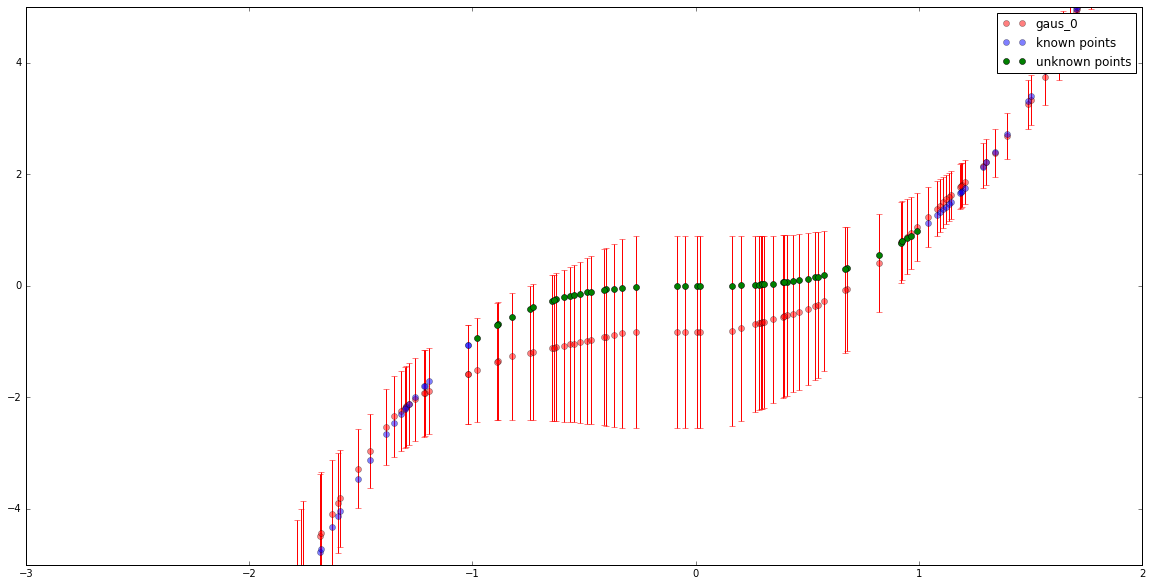

In [290]:
mu_pred = mu_pred_s
sigma_pred = sigma_pred_s
alpha_pred = alpha_pred5
y_pred = np.zeros((len(mu_pred)))

col = cm.autumn(np.linspace(0, 1, mu_pred.shape[-1]))

for mx in xrange(mu_pred.shape[-1]):
    for i in xrange(len(mu_pred)):
        pyplot.errorbar(X_val[i],mu_pred[i,0,mx],
                        yerr=sigma_pred[i,mx],
                        alpha=alpha_pred[i,mx], 
                        color=col[mx])
        y_pred[i] = mu_pred[i,0,mx]
    pyplot.plot(X_val,y_pred, color=col[mx],linewidth=1, marker='o', 
            linestyle=' ',alpha=0.5, label='gaus_'+str(mx))

knownP = (((X_val>-4) & (X_val<-1)) | ((X_val>1) & (X_val<4)))

pyplot.plot(X_val[knownP],y_val[knownP], color='blue', 
            linewidth=1, marker='o', linestyle=' ',alpha=0.5, label='known points')

pyplot.plot(X_val[knownP==0],y_val[knownP==0], color='green', 
            linewidth=1, marker='o', linestyle=' ',alpha=1, label='unknown points')

axes = pyplot.gca()

from matplotlib import collections  as mc
axes.set_ylim(-5,5)
axes.set_xlim(-3,2)
pyplot.gcf().set_size_inches((20,10))
pyplot.legend()
print 'Absolute error', np.min(np.abs(np.expand_dims(y_val,axis=2)-mu_pred),axis=2).sum()

Absolute error 71076.6


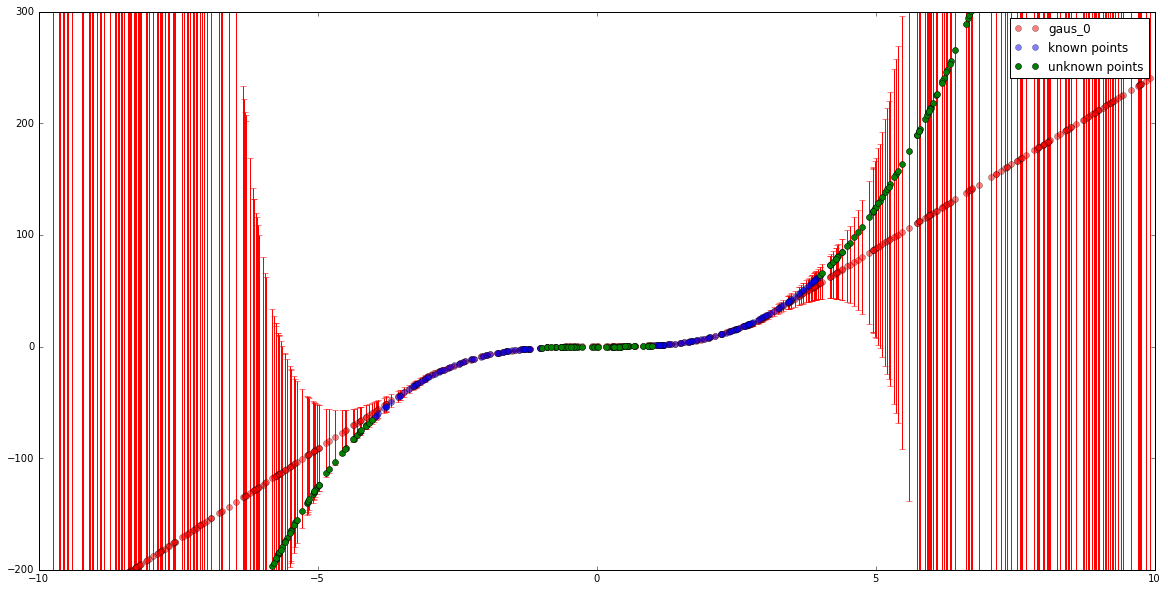

In [235]:
mu_pred = mu_pred_s
sigma_pred = sigma_pred_s
alpha_pred = alpha_pred5
y_pred = np.zeros((len(mu_pred)))

col = cm.autumn(np.linspace(0, 1, mu_pred.shape[-1]))

for mx in xrange(mu_pred.shape[-1]):
    for i in xrange(len(mu_pred)):
        pyplot.errorbar(X_val[i],mu_pred[i,0,mx],
                        yerr=sigma_pred[i,mx],
                        alpha=alpha_pred[i,mx], 
                        color=col[mx])
        y_pred[i] = mu_pred[i,0,mx]
    pyplot.plot(X_val,y_pred, color=col[mx],linewidth=1, marker='o', 
            linestyle=' ',alpha=0.5, label='gaus_'+str(mx))

knownP = (((X_val>-4) & (X_val<-1)) | ((X_val>1) & (X_val<4)))

pyplot.plot(X_val[knownP],y_val[knownP], color='blue', 
            linewidth=1, marker='o', linestyle=' ',alpha=0.5, label='known points')

pyplot.plot(X_val[knownP==0],y_val[knownP==0], color='green', 
            linewidth=1, marker='o', linestyle=' ',alpha=1, label='unknown points')

axes = pyplot.gca()
#origins = zip(np.arange(rang)*1.,y_val)
#endings = zip(np.arange(rang)*1.,y_pred)
#lines_vals = [[origins[i],endings[i]] for i in xrange(len(origins))]

from matplotlib import collections  as mc
#lc = mc.LineCollection(lines_vals, linewidths=1, alpha = 0.4, color = 'purple')
#axes.add_collection(lc)
axes.set_ylim(-200,300)
axes.set_xlim(-10,10)
pyplot.gcf().set_size_inches((20,10))
pyplot.legend()
print 'Absolute error', np.min(np.abs(np.expand_dims(y_val,axis=2)-mu_pred),axis=2).sum()